___

#### Group 2:
#### DJ Dawkins, Rick Fontenot, Joe Lazarus, Puri Rudick
___


<a id="main"></a>
# Lab 3: Clustering

This Notebook will cover the following topics in order: 

1) 
 

In addition to evaluating clustering effectiveness with SSE and Silhouette metrics, we will also evaluate whether location clustering improves regression models to predict airbnb prices.

From previous modeling we know that beyond location, the most important features in predicting price are:
room_type
num_baths (to be extracted from the bathrooms_text in the raw file)
accommodates
availability_30

For Location features we will compare:
1) neighbourhood_group_cleansed
2) listing unique latitude & longitude
3) various clustering methods using latitude & longitude

We will reduce our base dataset to these features and add one-hot encoded clustering for each algorithm to compare price regression performance with MAE and R^2

In [1]:
#list of columns to import
col_list = ["id", "price", "room_type", "bathrooms_text", "accommodates", "availability_30", "latitude", "longitude", "neighbourhood_group_cleansed"]


<a id="Prologue"></a>
# Preliminary Data Preparation
Cleaning raw data and new feature creation

- Imports
- load data
- Data Quality 
- New Features
- Check missing values
- handling missing values
- check for duplicates

In [2]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import date
import sklearn
pd.set_option("display.max_columns", None, "display.max_rows", None)
import missingno as msno


### Load the raw data

NYC Airbnb data obtained from http://data.insideairbnb.com/united-states/ny/new-york-city/2021-08-04/data/listings.csv.gz

In [3]:
# Load Raw Data
listings=pd.read_csv("https://raw.githubusercontent.com/rickfontenot/airbnb/main/airbnb_nyc_listings.csv?token=ARN5NNHQQO5DGH6T72FBV2DBGD342", usecols=col_list)

listings.head()

,id,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,price,availability_30
0,2595,Manhattan,40.75356,-73.98559,Entire home/apt,1,1 bath,$150.00,6
1,3831,Brooklyn,40.68494,-73.95765,Entire home/apt,3,1 bath,$75.00,0
2,5121,Brooklyn,40.68535,-73.95512,Private room,2,NaN,$60.00,30
3,5136,Brooklyn,40.66265,-73.99454,Entire home/apt,4,1.5 baths,$275.00,7
4,5178,Manhattan,40.76457,-73.98317,Private room,2,1 bath,$61.00,3


In [4]:
# Examin Data types
listings.dtypes


id                                int64
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
room_type                        object
accommodates                      int64
bathrooms_text                   object
price                            object
availability_30                   int64
dtype: object

### Regular Expressions
**Price** : our other target variable, is currently an object data type. We need to convert this to a floating point integer. This requires the use of a regular expression to remove "$" and "," from string and convert to float.

In [5]:
print(listings.price.dtypes) #initial type is object
print(listings.price.loc[[299]]) #original value "$2,500.00"
listings.price = listings.price.replace('[\$,]', '', regex=True).astype(float)
print(listings.price.dtypes) #transformed type is float64
print(listings.price.loc[[299]]) #new value is 2500.0

object
299    $2,500.00
Name: price, dtype: object
float64
299    2500.0
Name: price, dtype: float64


**Text Parsing**  bathrooms_text in its current form is not atomized. Meaning it contains more than more piece of information. It contains the Numeric quantity bathrooms and string values describing if it is shared or private. Create dictionary to parse strings and create two new variables of correct type.<br>
<br />

This work goes beyond the scope of data type and into **Data Quality** and **New Features** If we decide to present this for credit, we will present this work again in those sections.<br>
<br/>
Two new columns are being created from *bathroom_text*: **num_baths** and **bath_type**
- **num_baths** will be a floating point value
- **bath_type** will be a categorical value.

In [6]:
#convert nAn values to 'NA' for parsing, will change back to nAn after splitting
listings['bathrooms_text'] = listings['bathrooms_text'].astype(object).replace(np.nan, 'NA')

#Create translation dictionary since description formats are not consistent
transdict = {'1 bath': '1 private', 
             'NA': 'NA',
             '1.5 baths': '1.5 private',
             '1 shared bath': '1 shared', 
             '1 private bath': '1 private',
             'Shared half-bath': '0.5 shared',
             '2 baths': '2 private',
             '1.5 shared baths': '1.5 shared',
             '3 baths': '3 private',
             'Half-bath': '0.5 private',
             '2.5 baths': '2.5 private', 
             '2 shared baths': '2 shared',
             '0 baths' : '0 private',
             '4 baths':'4 private', 
             '0 shared baths': '0 shared',
             'Private half-bath': '0.5 private',  
             '4.5 baths' :'4.5 private', 
             '5.5 baths': '5.5 private' , 
             '2.5 shared baths': '2.5 shared',
             '3.5 baths': '3.5 private', 
             '15.5 baths': '15.5 private', 
             '5 baths': '5 private', 
             '3 shared baths': '3 shared', 
             '4 shared baths': '4 shared',
             '6 baths': '6 private', 
             '3.5 shared baths': '3.5 private', 
             '6 shared baths' : '6 shared',
             '6.5 shared baths': '6.5 shared', 
             '4.5 shared baths' :'4.5 private',
             '5.5 shared baths' : '5.5 private', 
             '7.5 baths': '7.5 private', 
             '5 shared baths': '5 shared',
             '6.5 baths': '6.5 private', 
             '8 baths': '8 private', 
             '7 shared baths':'7 shared', 
             '7 baths': '7 private', 
             '10 baths': '10 private'}

#use trandict to iterate over bathrooms_text column
listings['bathrooms_text'] = [transdict[letter] for letter in listings['bathrooms_text']]

#use str.split to create two new columns 'num_baths' and 'bath_type'
listings[['num_baths','bath_type']] = listings['bathrooms_text'].str.split(' ', 1, expand = True)

#For num_baths convert 'NA' values back to nan and convert type to float
listings['num_baths'] = listings['num_baths'].astype(object).replace( 'NA',np.nan)
listings['num_baths'] = listings['num_baths'].astype(np.float16)

#For bath type convert 'NA' values back to nan and convert type to category
listings.bath_type.fillna(value=np.nan, inplace=True)
listings['bath_type'] = listings['bath_type'].astype('category')
 


### Dropping bathroom_text 
num_baths and bath_type now represent the data that was contained in bathroom_text

In [7]:
#Confirm conversions for bathroom text
print(listings.num_baths.dtypes) #transformed type is float16
print(listings.num_baths.unique())
print(listings.bath_type.dtypes) #transformed type is category
print(listings.bath_type.unique()) 

#Drop original bathrooms_text column now that replaced by two new variables
listings.drop('bathrooms_text', axis=1, inplace=True)

float16
[ 1.   nan  1.5  0.5  2.   3.   2.5  0.   4.   4.5  5.5  3.5 15.5  5.
  6.   6.5  7.5  8.   7.  10. ]
category
['private', NaN, 'shared']
Categories (2, object): ['private', 'shared']


### Check Work
Check current data types for all variables before converting to desired types

In [8]:
print(listings.dtypes)

id                                 int64
neighbourhood_group_cleansed      object
latitude                         float64
longitude                        float64
room_type                         object
accommodates                       int64
price                            float64
availability_30                    int64
num_baths                        float16
bath_type                       category
dtype: object


### Data Type Dictionary
In this step we are coercing the pandas to recognize the columns in the data type that best represents each particular type of observation.<br>
<br />
To do so Data Type dictionary is created and convert all variables to proper format and bit sizes based on the key value pair.

In [9]:
convert_dict = {
'neighbourhood_group_cleansed': 'category',
'room_type': 'category',
'accommodates': 'Int16',
'price': 'float64',
'availability_30': 'Int16',
'num_baths': 'float64',
'bath_type': 'category'
               }
  
listings = listings.astype(convert_dict, errors='ignore')
print(listings.dtypes)

id                                 int64
neighbourhood_group_cleansed    category
latitude                         float64
longitude                        float64
room_type                       category
accommodates                       Int16
price                            float64
availability_30                    Int16
num_baths                        float64
bath_type                       category
dtype: object


### Check missing values
This check is done to ensure we've preserved the data integrity and its missing values.

In [10]:
listings.isna().sum()

id                                0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
room_type                         0
accommodates                      0
price                             0
availability_30                   0
num_baths                       109
bath_type                       109
dtype: int64

## Preserving variables with missing values

For variables with  less than 1,000 missing values (less than 2.7% of observations), we chose not to impute. It may be the case that the lack of data is data in and of itself. Guests may be influenced by the lack of data when choosing a listing. During our analyses we will consider this. In certain cases we may filter. <br><br /> Those variables are:
* num_baths (new variable)
* bath_type (new variable)

In [11]:
print("Dataframe Size before dropping NA: ",listings.shape)
listings.dropna(inplace= True)
print("Dataframe Size after dropping NA: ",listings.shape)

print(listings.isna().sum())


Dataframe Size before dropping NA:  (36724, 10)
Dataframe Size after dropping NA:  (36615, 10)
id                              0
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
room_type                       0
accommodates                    0
price                           0
availability_30                 0
num_baths                       0
bath_type                       0
dtype: int64


## Check for Duplicate Data

In [12]:
# Check for duplicate rows
print('Duplicate rows: ',listings.duplicated(keep='first').sum())


Duplicate rows:  0


<a id="dataReg"></a>
___
# Data Preparation Part 1: *Regression*
___
#### [15 points total] 

One-hot encode categorical variables then drop originals.

In [13]:
Categoricals_to_convert = ['neighbourhood_group_cleansed','room_type','bath_type']

# using pd get dummies for the category columns we are keeping
dummies = pd.get_dummies(listings[Categoricals_to_convert],drop_first=True)

#dropping original columns
listings_df = listings.drop(Categoricals_to_convert,axis=1)

#concating dummies to the data frame
listings_df = pd.concat([listings_df,dummies],axis=1)

listings_df.head()

,id,latitude,longitude,accommodates,price,availability_30,num_baths,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room,bath_type_shared
0,2595,40.75356,-73.98559,1,150.0,6,1.0,0,1,0,0,0,0,0,0
1,3831,40.68494,-73.95765,3,75.0,0,1.0,1,0,0,0,0,0,0,0
3,5136,40.66265,-73.99454,4,275.0,7,1.5,1,0,0,0,0,0,0,0
4,5178,40.76457,-73.98317,2,61.0,3,1.0,0,1,0,0,0,1,0,0
5,5203,40.80380,-73.96751,1,75.0,0,1.0,0,1,0,0,0,1,0,1


<AxesSubplot:>

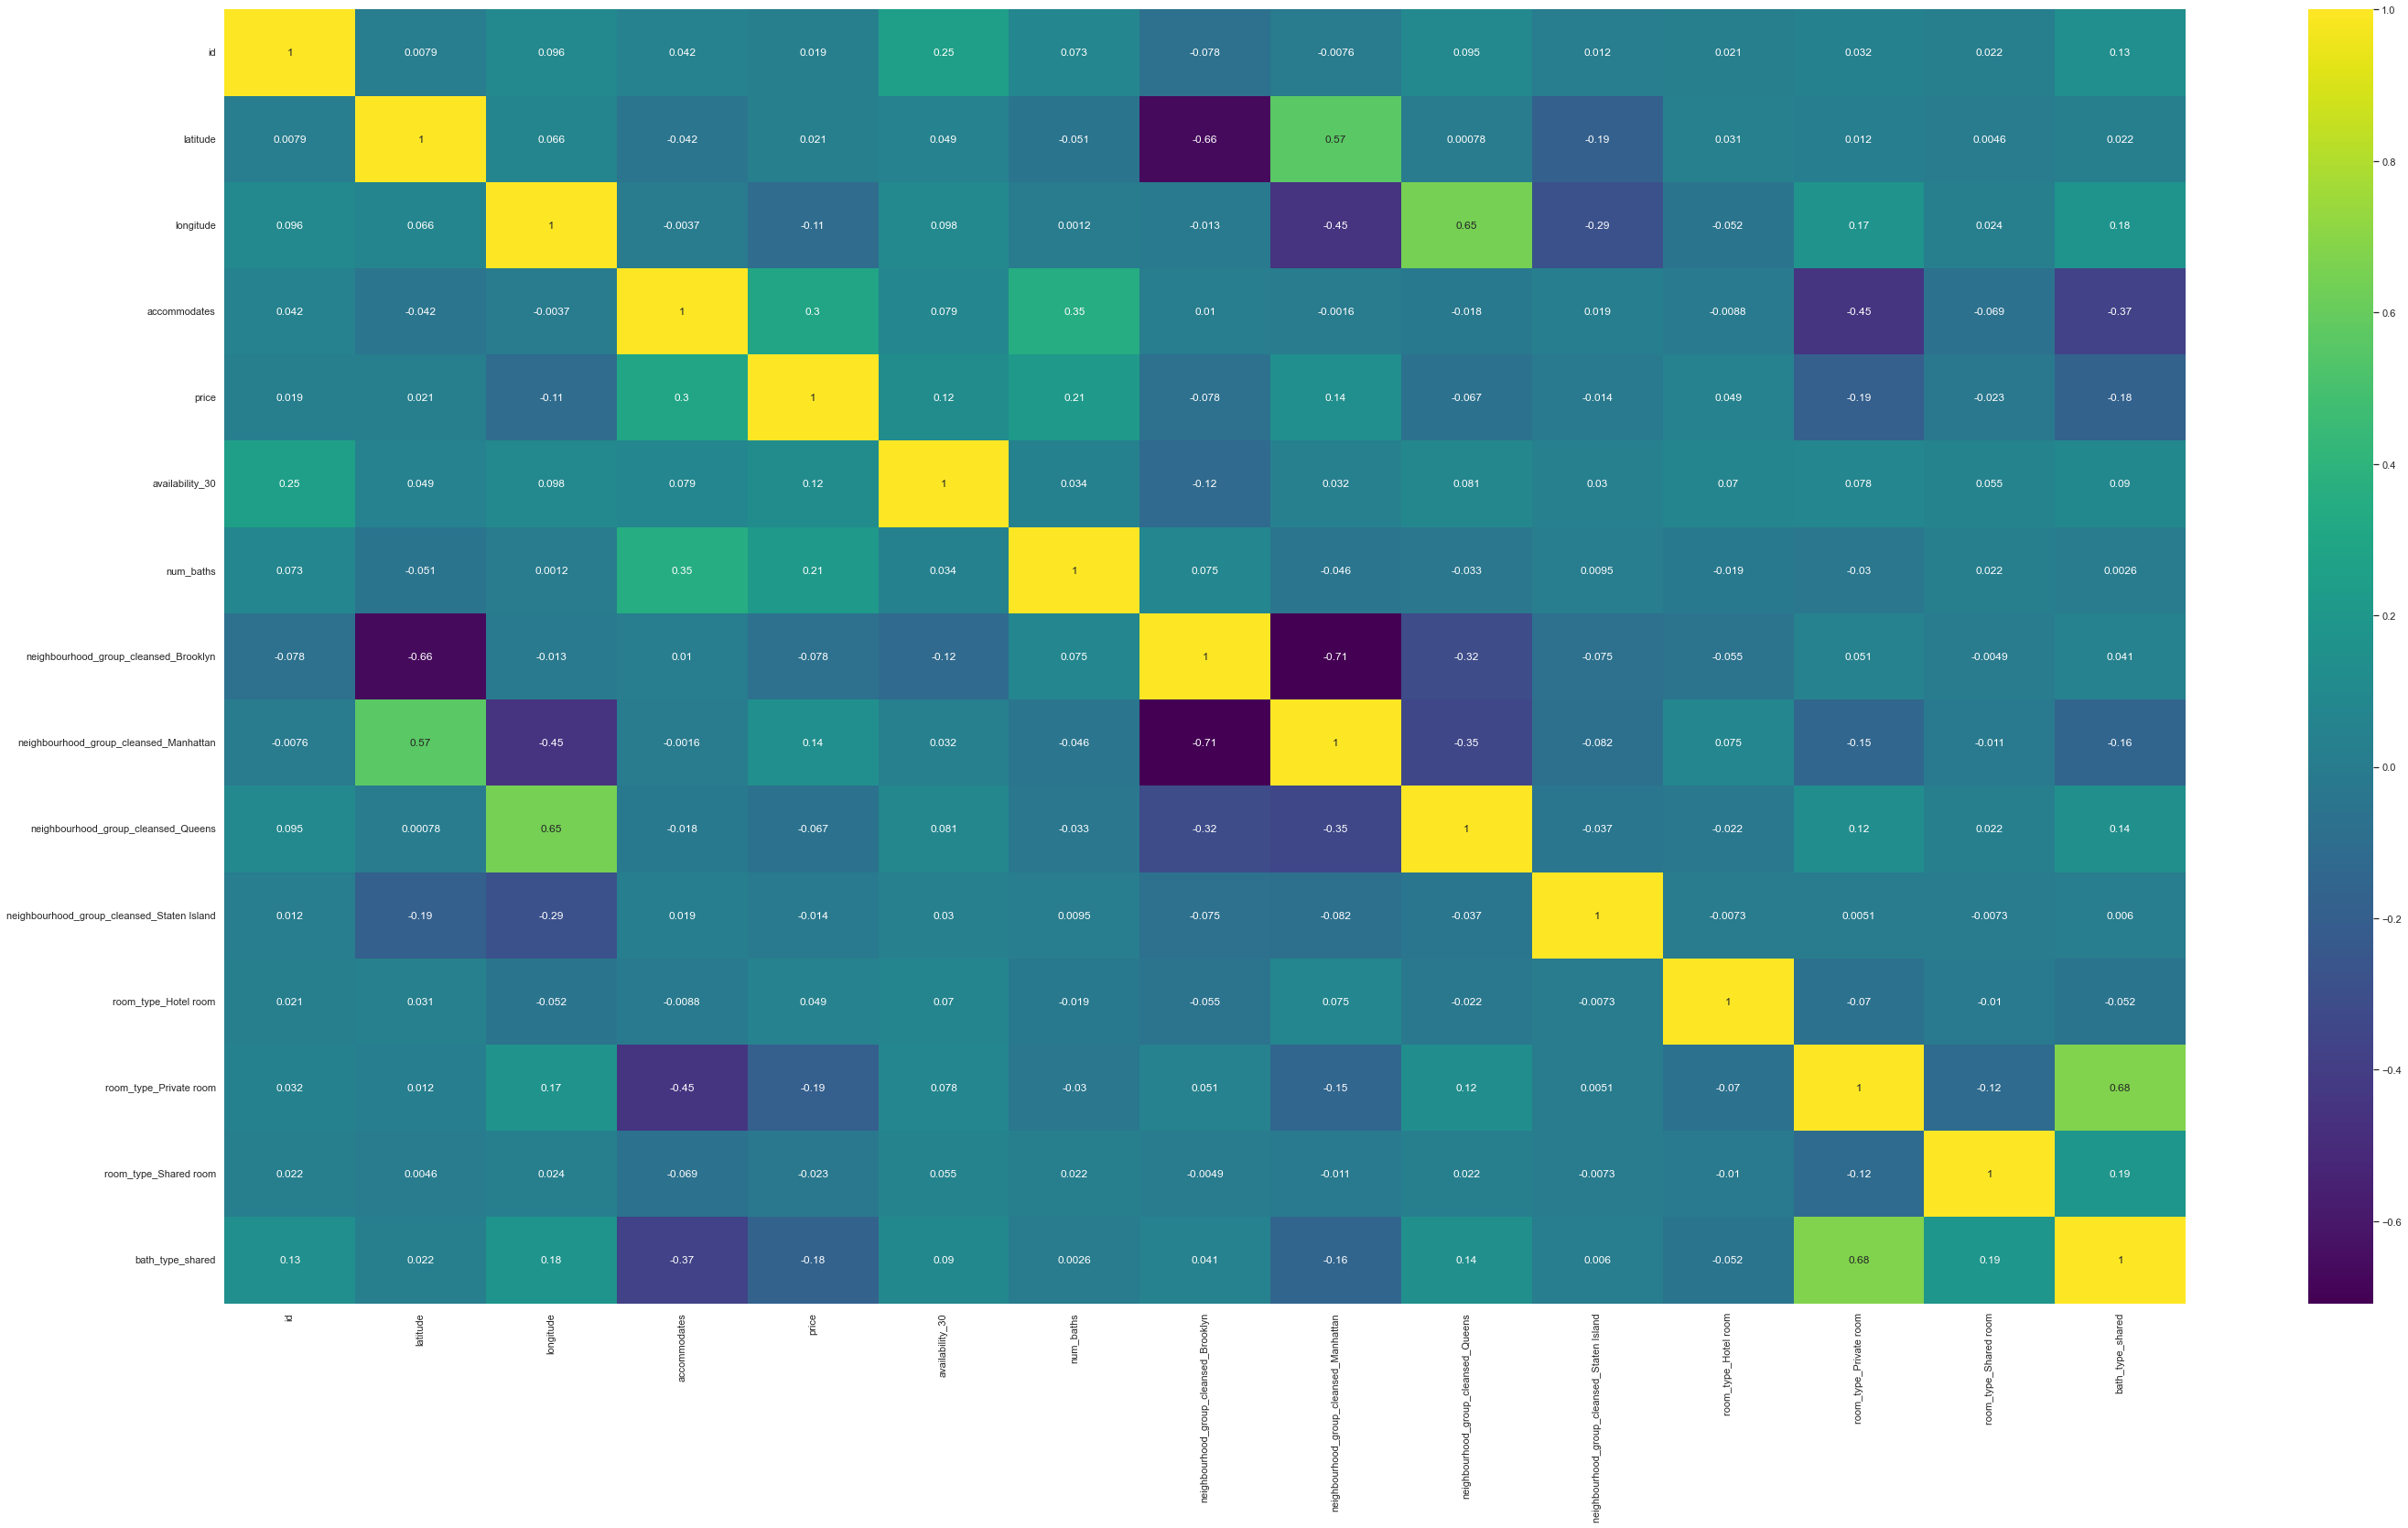

In [14]:
plt.figure(figsize=(48,26))
sns.set(font_scale=1)
sns.heatmap(listings_df.corr(),annot=True,cmap='viridis')

## A closer look on response variable, **Price**

From the histogram and QQ-plot, the variable show heavily righ-skewed distribution.

Skewness: 19.861454
Kurtosis: 574.877327


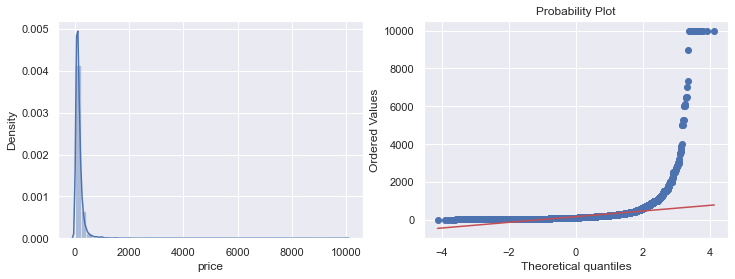

In [15]:
import matplotlib
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.distplot(listings_df['price'], ax=ax[0])
stats.probplot(listings_df['price'], dist="norm", plot=ax[1])

print("Skewness: %f" % listings_df['price'].skew())
print("Kurtosis: %f" % listings_df['price'].kurt())

Log transformation might help making the response variable more normally distributed.

Skewness: 0.703872
Kurtosis: 1.459337


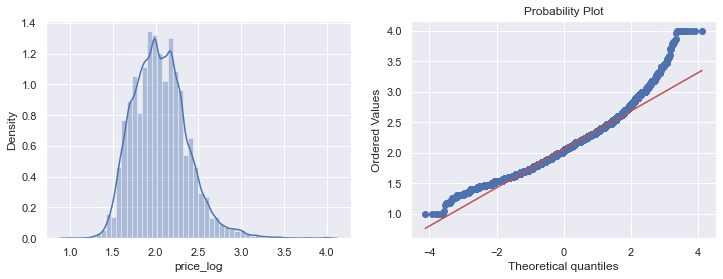

In [16]:
listings_df['price_log'] = np.log10(listings_df['price'])

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.distplot(listings_df['price_log'], ax=ax[0])
stats.probplot(listings_df['price_log'], dist="norm", plot=ax[1])

print("Skewness: %f" % listings_df['price_log'].skew())
print("Kurtosis: %f" % listings_df['price_log'].kurt())

### **Remove Outliers and describe target variable**

**Normalizing the data:**
With log transformation, both histogram and QQ plot show much more normal distribution of price

**Investigation of outliers:**
We then dig into more details for each extremely high and low price listings by going through their urls.  We found that:

**All listings above 5,000 USD** are either 
- Hotel advertisement lisitings with zero availability which do not allow guests to book through Airbnb
- Normal listings with zero availability which do not allow guests to book and/or hosts have not been active for over a year.  This looks like the hosts set the extremely high price to deactivate the listings without deleting from Airbnb website.

**All listings below 14 USD** (yes!  you can stay in NYC for 14 USD a night, exchange for cats sittng for the host) are either
- Hotel advertisement lisitings with zero availability which do not allow guests to book through Airbnb
- Normal listings with zero availability which do not allow guests to book.  This looks like the hosts set the extremely low price to deactivate the listings without deleting from Airbnb website.

We decided to leave the listings less than 14 USD and above 5,000 USD out from the dataset.  The histogram and QQ-plot still shows little right skewed distribution but over all look more normally distributed.

**Describe target variable:**
___
Price is our target variable. In order to normalize our data Log transformation is utilized. The target variable for all regression model is log_price.
___
* **price** -  Float16 value indicating the cost per night to stay at the listing. Values range from 0 – 10,000 in U.S. Dollars. There are 853 unique values in this column.
> **price_log** - is the natural log of price. <br>

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

Skewness: 0.593605
Kurtosis: 0.757704


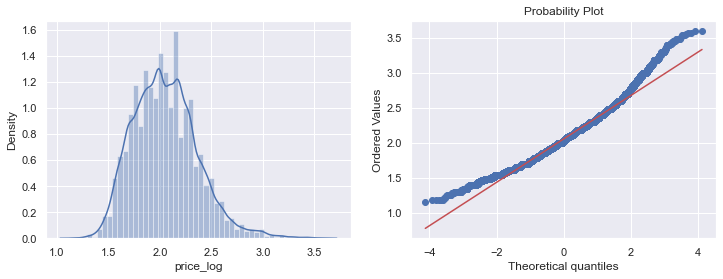

In [17]:
listings_cleaned = listings_df[(listings_df.price >= 14) & (listings_df.price < 5000)]
listings_cleaned['price_log'] = np.log10(listings_cleaned['price'])

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.distplot(listings_cleaned['price_log'], ax=ax[0])
stats.probplot(listings_cleaned['price_log'], dist="norm", plot=ax[1])

print("Skewness: %f" % listings_cleaned['price_log'].skew())
print("Kurtosis: %f" % listings_cleaned['price_log'].kurt())

In [18]:
listings_cleaned.shape

(36579, 16)

### Shape of final dataset
The final dataset that we will model with has 35,919 unqiue observations. with 42 columns that we will describe below. 

In [19]:
listings_cleaned.columns

Index(['id', 'latitude', 'longitude', 'accommodates', 'price',
       'availability_30', 'num_baths', 'neighbourhood_group_cleansed_Brooklyn',
       'neighbourhood_group_cleansed_Manhattan',
       'neighbourhood_group_cleansed_Queens',
       'neighbourhood_group_cleansed_Staten Island', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'bath_type_shared',
       'price_log'],
      dtype='object')

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

**Create functions to evaluate regression estimators** (MAE, MAPE, RMSE, and R-squared)

Credit: <a>https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb</a>


In [20]:
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score

def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)
r2_scorer = make_scorer(score_func=r2_score, greater_is_better=True)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer,
                'R2': r2_scorer
               } 

### Methodology for dividing your Data : *Regression*

We will brief exceptions for to our methodology described that are unique to the regression task. 

> stratification was not used in the when seperating the data for validationa and cross-fold. Price is a continous variable. Unlike our classification task that looked at a binary True/False status of superhost. Price ranged from 14 - 5,000 dollars. Rather than impliment a someone arbituary cut off value, we left it alone. Randomization is used to extract validation and cross validation samples across the k folds. 
<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

In [21]:
#Split Modeling and Validation Datasets
from sklearn.model_selection import train_test_split

listings_modeling, listings_validation = train_test_split(listings_cleaned, test_size=0.1, random_state=42)

print("Size of modeling set (to be CV split): ",listings_modeling.shape)
print("Size of hold back validation set: ",listings_validation.shape)

Size of modeling set (to be CV split):  (32921, 16)
Size of hold back validation set:  (3658, 16)


In [22]:
#Create X and Y for modeling
X_price = listings_modeling.drop(['price','price_log','id'],axis=1) #droping rating_max
Y_price_log = listings_modeling['price_log']

#Create new X and Y for validation
X_price_valid = listings_validation.drop(['price','price_log','id'],axis=1) #droping rating_max
Y_price_log_valid = listings_validation['price_log']

In [23]:
#Standard scale the data
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

std.fit(X_price.values) # only std.fit on train set
X_price_std = std.transform(X_price.values)
X_price_valid_std = std.transform(X_price_valid.values)

## **Cross Validation**
Cross validation is performed using repeated holdout via KFold()

- Ten folds are used
- The split is: 90% training data and 10% test data
- A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [24]:
from sklearn.model_selection import KFold

cv_price = KFold(n_splits=10, shuffle=False)


> 
> ## Modeling and Evaluation 3:
> Create three different *Classification* models (e.g., random forest, KNN, and Logistic Regression).
> 

Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization

> #### [20 points]

Eight regression models were conducted using GridSearchCV to find the best regression model that fit the modeling dataset.
1) Linear Regression
2) Ridge Regression
3) Lasso Regression
4) Elastic Net Regression
5) Support Vector Regression
6) Random Forest Regressor
7) Extra Trees Regressor
8) K Neighbors Regressor



We created 2 functions for regression model and residual plots as below.

In [25]:
#Create function for regression models
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(modelNme, regEstimator, X, y, x_valid, y_valid, cv):
    
    print('Parameterization of the best estimator:',regEstimator,'\n')

    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    yhat = regEstimator.predict(x_valid)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean RMSE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))

    #print R2 for all folds 
    R2avg = scores['test_R2'].mean()
    print_str = "The average R2 for all cv folds is: \t\t\t {R2avg:.5}"
    print(print_str.format(R2avg=R2avg))
    print('---------------------------------------------------------------------')

    model_stat = pd.DataFrame()
    model_stat['Model_name'] = [str(modelNme)]
    model_stat['MAE_model'] = scores['test_MAE'].mean()
    model_stat['MAPE_model'] = scores['test_MAPE'].mean()
    model_stat['RMSE_model'] = scores['test_RMSE'].mean()
    model_stat['R2_model'] = scores['test_R2'].mean()
    model_stat['MAE_validation'] = mean_absolute_error(y_valid, yhat)
    model_stat['MAPE_validation'] = mape(y_valid, yhat)
    model_stat['RMSE_validation'] = rmse(y_valid, yhat)
    model_stat['R2_validation'] = r2_score(y_valid, yhat)

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    scoresResults['R2'] = scores['test_R2']
    print(scoresResults)
    
    return model_stat, model_stat['MAE_validation']

In [26]:
#Create Function for Prediction Error, Residual and Cook's D Plots
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import CooksDistance

def residualPlot(model, x_train, y_train, x_test, y_test):
    print('\n*********************************************\nPrediction Error, Residual and Cook\'s D Plots\n*********************************************')

    predictions = model.predict(x_train)
    residuals = y_train - predictions
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(residuals))

    plt.subplots(1, 2, figsize=(14, 4))
    plt.subplot(121)
    visualizer = PredictionError(model)
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.finalize()

    plt.subplot(122)
    visualizer = ResidualsPlot(model, hist=False, qqplot=True)
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()
    plt.show()

    plt.subplots(1, 2, figsize=(13,4))    
    plt.subplot(121)
    sns.regplot(predictions, model_norm_residuals_abs_sqrt,
                scatter=True,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plt.ylabel("Standarized residuals")
    plt.xlabel("Fitted value")

    y = np.array(y_train, dtype=float)
    x = np.array(x_train, dtype=float)
    plt.subplot(122)
    visualizer = CooksDistance()
    visualizer.fit(x, y)
    visualizer.show()

In [27]:
#Create dataframe to collect regression models stat
regModel_stat = pd.DataFrame()

<a id="RFReg"></a>
# Base Random Forest Regressor using neighborhood_group_cleansed and raw latitude/longitude (no clustering)
GridSearchCV was run but the code took longer than 25 minutes to run, so we decided to comment the code for this part out to save time when we run the final notebook.  The best model from GridSearchCV as mentioned below. 

In [28]:
#Base model is RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500)

from sklearn.ensemble import RandomForestRegressor

rfRandomEstimator = RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500, n_jobs=8, random_state=0)
rfRandomEstimator.fit(X_price_std, Y_price_log)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
rf, rfMae = EvaluateRegressionEstimator('Random Forest Regressor', rfRandomEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(rf)

Parameterization of the best estimator: RandomForestRegressor(min_samples_leaf=10, min_samples_split=5,
                      n_estimators=500, n_jobs=8, random_state=0) 

The average MAE for all cv folds is: 			 0.13127
The average MAE percentage (MAPE) for all cv folds is: 	 6.3772
The average RMSE for all cv folds is: 			 0.18159
The average R2 for all cv folds is: 			 0.66471
---------------------------------------------------------------------
Cross Validation Fold Mean Error Scores
        MAE      MAPE      RMSE        R2
0  0.132317  6.462232  0.183365  0.642062
1  0.128631  6.241250  0.174927  0.685431
2  0.130921  6.338835  0.184824  0.664396
3  0.133186  6.485113  0.183796  0.649419
4  0.130472  6.359707  0.178534  0.689187
5  0.129460  6.305482  0.178350  0.665725
6  0.135215  6.497637  0.192900  0.638289
7  0.129271  6.299239  0.176694  0.681378
8  0.133103  6.432136  0.184965  0.653259
9  0.130116  6.349894  0.177573  0.677930


In [29]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
randomForrestReg_weights = rfRandomEstimator.feature_importances_.ravel()
randomForrestReg_feature_names = X_price_valid.columns.values
randomForrestReg_ft_imp_df = pd.DataFrame({'feature_names':randomForrestReg_feature_names, 'weights':randomForrestReg_weights, 'absolute_weights': np.abs(randomForrestReg_weights)})
randomForrestReg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False)

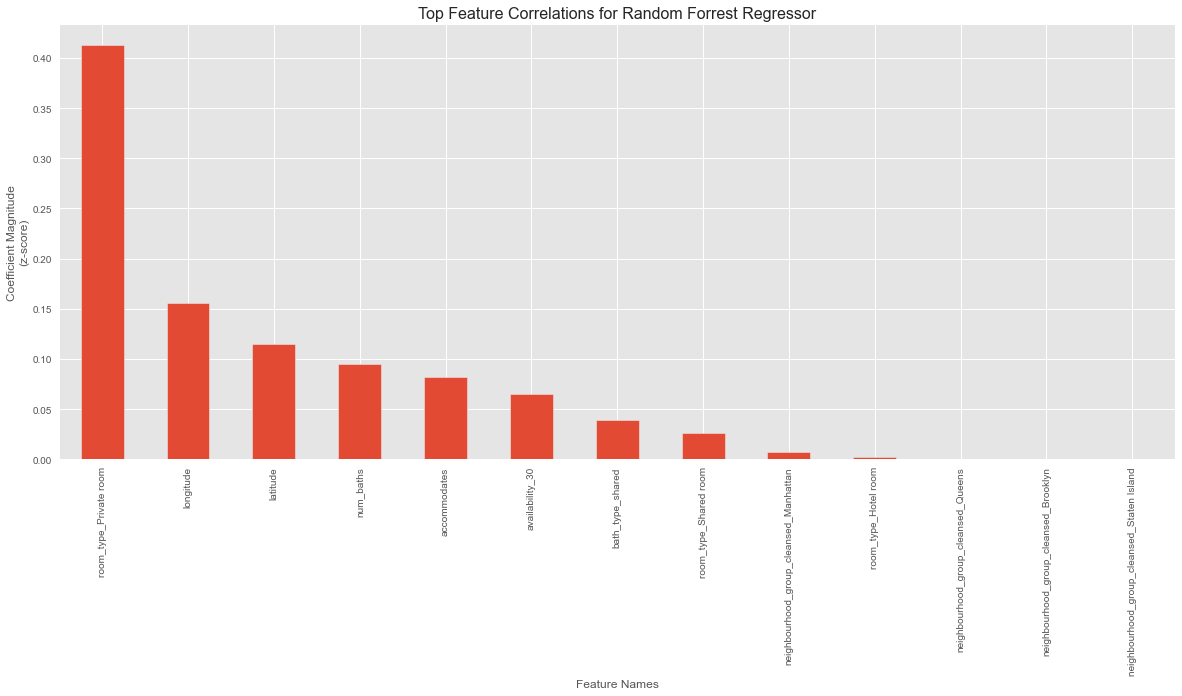

In [30]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

randomForrestReg_wt_plt_df = randomForrestReg_ft_imp_df.head(75)

randomForrestReg_weights = pd.Series(randomForrestReg_wt_plt_df['weights'].values,index=randomForrestReg_wt_plt_df['feature_names'])
ax = randomForrestReg_weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations for Random Forrest Regressor", fontsize=16)
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

## **EPS Tuning**
### Using Silehouette analysis & Kmeans algorithm to find the ideal no. of clusters for the data

In [ ]:
Lat_val = listings_validation.latitude
Long_val = listings_validation.longitude

LatLong_val = np.column_stack((Lat_val, Long_val))

LatLong_val.shape

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

In [ ]:
#Create X and Y for modeling
X_price = listings_modeling.drop(['id','price','price_log','latitude','longitude'],axis=1) #droping rating_max
Y_price_log = listings_modeling['price_log']

#Create new X and Y for validation
X_price_valid = listings_validation.drop(['id','price','price_log','latitude','longitude'],axis=1) #droping rating_max
Y_price_log_valid = listings_validation['price_log']

#Standard scale the data
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

std.fit(X_price.values) # only std.fit on train set
X_price_std = std.transform(X_price.values)
X_price_valid_std = std.transform(X_price_valid.values)

In [ ]:
#Create function for regression models
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(modelNme, regEstimator, X, y, x_valid, y_valid, cv):
    
    print('Parameterization of the best estimator:',regEstimator,'\n')

    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    yhat = regEstimator.predict(x_valid)

    #cross val score sign-flips the outputs
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    model_stat = pd.DataFrame()
    model_stat['Model_name'] = [str(modelNme)]
    model_stat['MAE_model'] = scores['test_MAE'].mean()
    model_stat['MAPE_model'] = scores['test_MAPE'].mean()
    model_stat['RMSE_model'] = scores['test_RMSE'].mean()
    model_stat['R2_model'] = scores['test_R2'].mean()
    model_stat['MAE_validation'] = mean_absolute_error(y_valid, yhat)
    model_stat['MAPE_validation'] = mape(y_valid, yhat)
    model_stat['RMSE_validation'] = rmse(y_valid, yhat)
    model_stat['R2_validation'] = r2_score(y_valid, yhat)
    
    return model_stat, model_stat['MAE_validation']

In [ ]:
rfRandomEstimator = RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500, n_jobs=8, random_state=0)
rfRandomEstimator.fit(X_price_std, Y_price_log)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
a, b = EvaluateRegressionEstimator('Random Forest Regressor', rfRandomEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)


In [ ]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
randomForrestReg_weights = rfRandomEstimator.feature_importances_.ravel()
randomForrestReg_feature_names = X_price_valid.columns.values
randomForrestReg_ft_imp_df = pd.DataFrame({'feature_names':randomForrestReg_feature_names, 'weights':randomForrestReg_weights, 'absolute_weights': np.abs(randomForrestReg_weights)})
randomForrestReg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False)

In [ ]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

randomForrestReg_wt_plt_df = randomForrestReg_ft_imp_df.head(75)

randomForrestReg_weights = pd.Series(randomForrestReg_wt_plt_df['weights'].values,index=randomForrestReg_wt_plt_df['feature_names'])
ax = randomForrestReg_weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations for Random Forrest Regressor", fontsize=16)
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

---

## Longitude and Lattitude are the 2nd and 3rd most important features. Now let's see if clustering on latitude vs. longitude can improve regression performance

In [31]:
listings_modeling.head()

,id,latitude,longitude,accommodates,price,availability_30,num_baths,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room,bath_type_shared,price_log
19277,29828333,40.82263,-73.94332,6,230.0,30,2.0,0,1,0,0,0,0,0,0,2.361728
5702,7397649,40.76297,-73.92696,3,132.0,0,1.0,0,0,1,0,0,0,0,0,2.120574
33666,49289061,40.75772,-73.99546,3,299.0,30,1.0,0,1,0,0,0,0,0,0,2.475671
29146,45115299,40.72779,-74.00050,2,126.0,0,1.0,0,1,0,0,0,0,0,0,2.100371
30590,46428638,40.70518,-74.00587,4,163.0,23,1.0,0,1,0,0,0,1,0,0,2.212188


Text(0.5, 1.0, 'Airbnb Listing Location by Latitude and Lontitude (Colored by Price in Log Scale)')

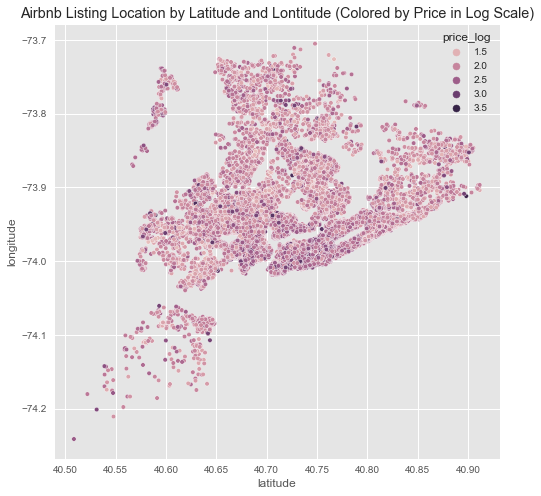

In [32]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=listings_cleaned, x='latitude', y='longitude', hue='price_log', s=20)
plt.title('Airbnb Listing Location by Latitude and Lontitude (Colored by Price in Log Scale)')

In [33]:
Lat = listings_modeling.latitude
Long = listings_modeling.longitude

LatLong = np.column_stack((Lat, Long))

LatLong.shape

(32921, 2)

# DBSCAN


In [34]:
#Scale LatLong Dataset for DBSCAN uses
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

std.fit(LatLong) # only std.fit on train set
LatLong_std = std.transform(LatLong)

Use Kneighbors to explore values for min-points and eps hyperparameters

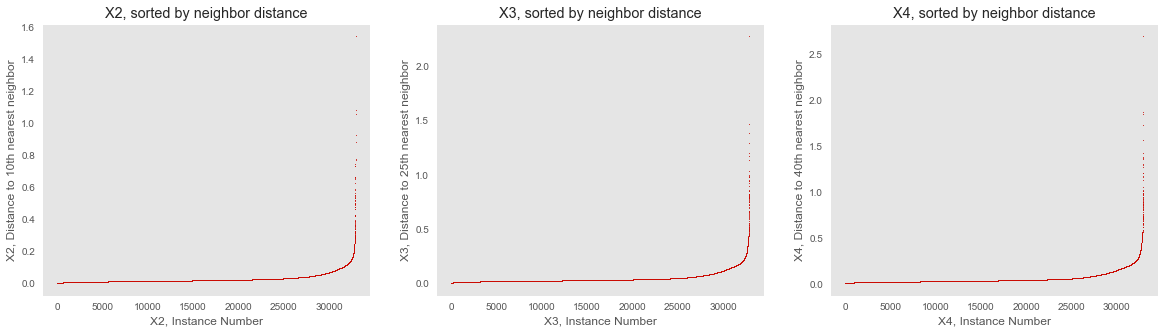

In [38]:
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X2_N = 10
X3_N = 25
X4_N = 40
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X2_knn_graph = kneighbors_graph(LatLong_std, X2_N, mode='distance') # calculate distance to four nearest neighbors 
X3_knn_graph = kneighbors_graph(LatLong_std, X3_N, mode='distance') # calculate distance to four nearest neighbors
X4_knn_graph = kneighbors_graph(LatLong_std, X4_N, mode='distance') # calculate distance to four nearest neighbors 

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = np.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = np.sort(X2_4nn_distances, axis=0)

N3 = X3_knn_graph.shape[0]
X3_4nn_distances = np.zeros((N3,1))
for i in range(N2):
    X3_4nn_distances[i] = X3_knn_graph[i,:].max()

X3_4nn_distances = np.sort(X3_4nn_distances, axis=0)

N4 = X4_knn_graph.shape[0]
X4_4nn_distances = np.zeros((N4,1))
for i in range(N2):
    X4_4nn_distances[i] = X4_knn_graph[i,:].max()

X4_4nn_distances = np.sort(X4_4nn_distances, axis=0)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('X2, sorted by neighbor distance')
plt.xlabel('X2, Instance Number')
plt.ylabel('X2, Distance to {0}th nearest neighbor'.format(X2_N))
#plt.ylim(0,.01)
plt.grid()

plt.subplot(1,3,2)
plt.plot(range(N3), X3_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('X3, sorted by neighbor distance')
plt.xlabel('X3, Instance Number')
plt.ylabel('X3, Distance to {0}th nearest neighbor'.format(X3_N))
#plt.ylim(0,.02)
plt.grid()

plt.subplot(1,3,3)
plt.plot(range(N4), X4_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('X4, sorted by neighbor distance')
plt.xlabel('X4, Instance Number')
plt.ylabel('X4, Distance to {0}th nearest neighbor'.format(X4_N))
#plt.ylim(0,.02)
plt.grid()

plt.show()

From the Distance to Nearest Neighbor charts above, we can see that:

- **X2: With min_samples = 10**, eps is somewhere between 0.1 - 0.2
- **X3: With min_samples = 25**, eps is somewhere between 0.2 - 0.5
- **X4: With min_samples = 40**, eps is somewhere between 0.2 - 0.5


eps = 0.25, Estimated number of clusters: 5
eps = 0.23, Estimated number of clusters: 5
eps = 0.20, Estimated number of clusters: 6
eps = 0.18, Estimated number of clusters: 11
eps = 0.15, Estimated number of clusters: 13
eps = 0.12, Estimated number of clusters: 23
eps = 0.10, Estimated number of clusters: 34
eps = 0.08, Estimated number of clusters: 50
eps = 0.05, Estimated number of clusters: 65
eps = 0.03, Estimated number of clusters: 96


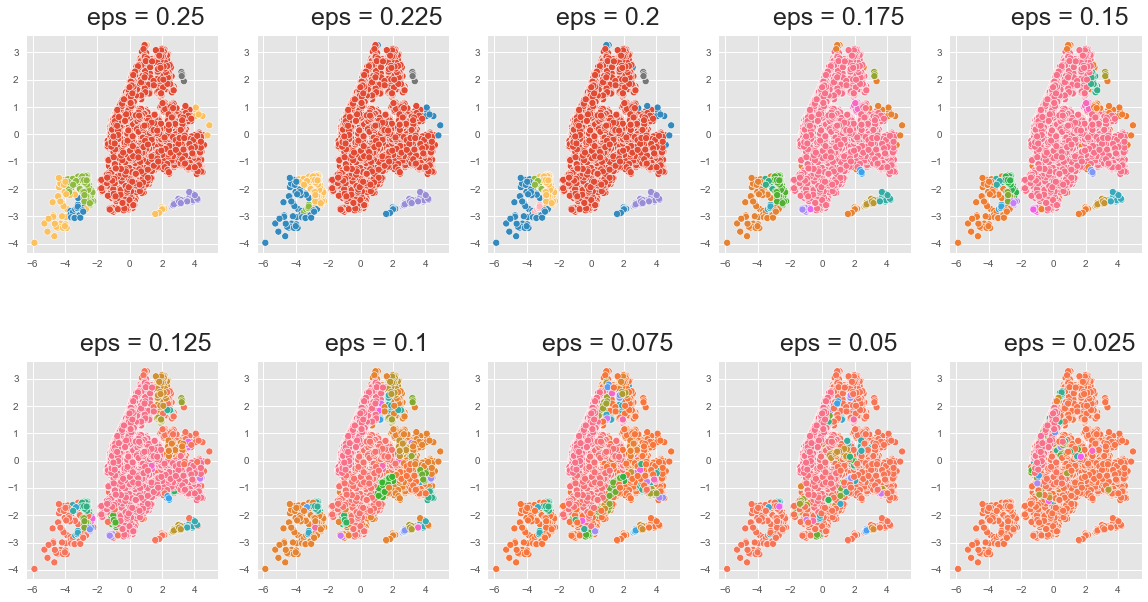

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
for x in range(10, 0, -1):
    eps = x*0.025
    db = DBSCAN(eps=eps, min_samples=10).fit(LatLong_std)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('eps = %0.2f, Estimated number of clusters: %d' % (eps, n_clusters_))
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 3)), fontsize=25, ha="center")
    sns.scatterplot(LatLong_std[:,1], LatLong_std[:,0], hue=["cluster-{}".format(x) for x in labels], legend=False)
    
    i += 1

eps = 0.50, Estimated number of clusters: 2
eps = 0.45, Estimated number of clusters: 3
eps = 0.40, Estimated number of clusters: 3
eps = 0.35, Estimated number of clusters: 3
eps = 0.30, Estimated number of clusters: 3
eps = 0.25, Estimated number of clusters: 4
eps = 0.20, Estimated number of clusters: 5
eps = 0.15, Estimated number of clusters: 17
eps = 0.10, Estimated number of clusters: 19
eps = 0.05, Estimated number of clusters: 15


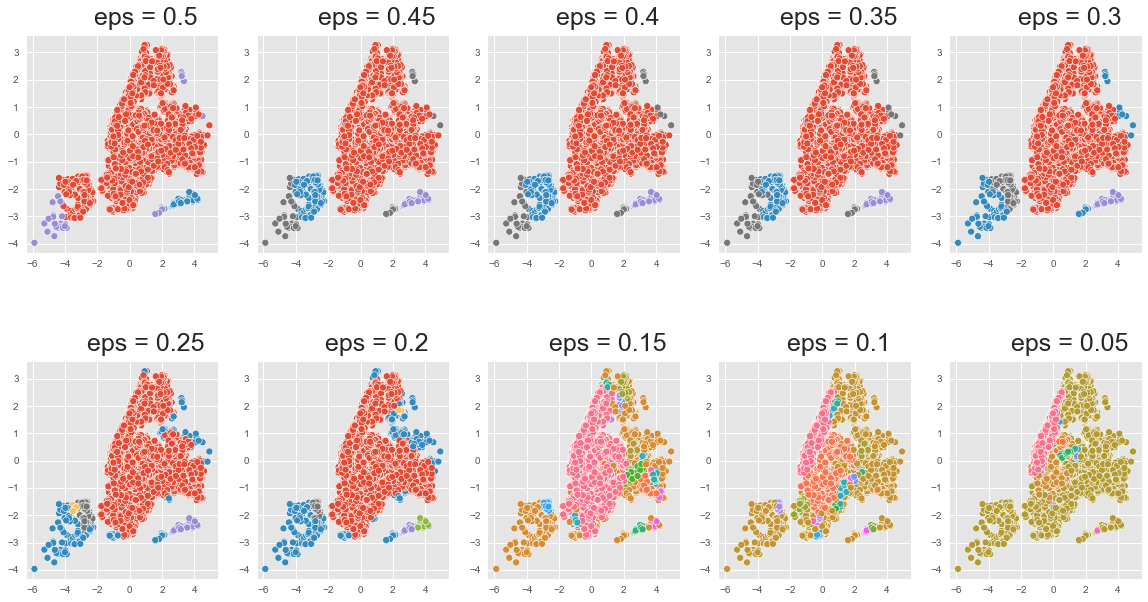

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
for x in range(10, 0, -1):
    eps = x*0.05
    db = DBSCAN(eps=eps, min_samples=25).fit(LatLong_std)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('eps = %0.2f, Estimated number of clusters: %d' % (eps, n_clusters_))
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 3)), fontsize=25, ha="center")
    sns.scatterplot(LatLong_std[:,1], LatLong_std[:,0], hue=["cluster-{}".format(x) for x in labels], legend=False)
    
    i += 1

eps = 0.50, Estimated number of clusters: 2
eps = 0.45, Estimated number of clusters: 3
eps = 0.40, Estimated number of clusters: 3
eps = 0.35, Estimated number of clusters: 3
eps = 0.30, Estimated number of clusters: 3
eps = 0.25, Estimated number of clusters: 5
eps = 0.20, Estimated number of clusters: 7
eps = 0.15, Estimated number of clusters: 12
eps = 0.10, Estimated number of clusters: 13
eps = 0.05, Estimated number of clusters: 21


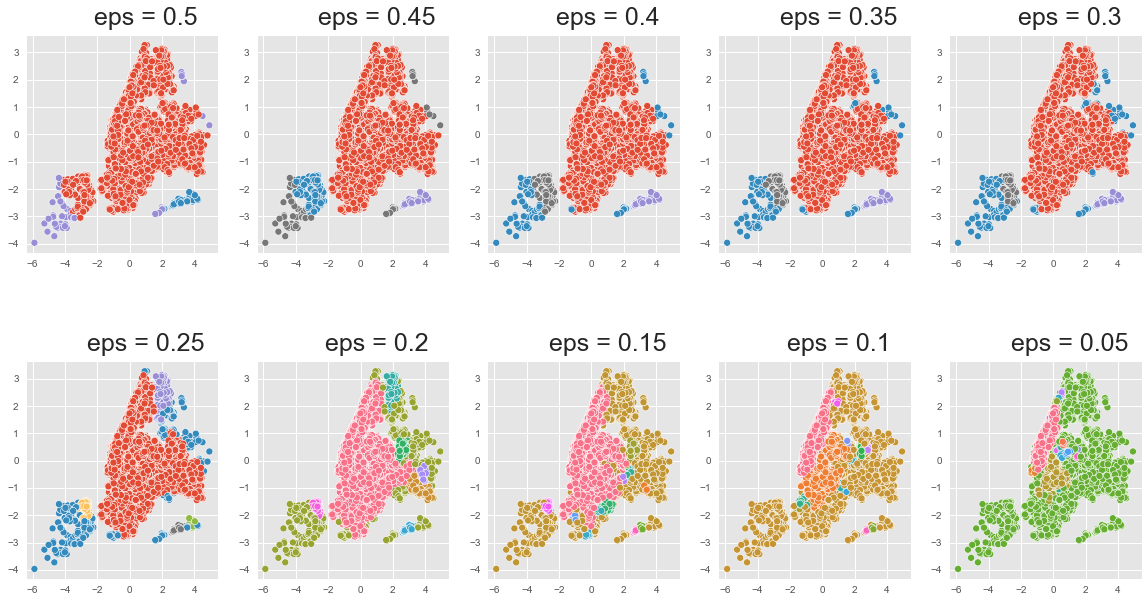

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
for x in range(10, 0, -1):
    eps = x*0.05
    db = DBSCAN(eps=eps, min_samples=40).fit(LatLong_std)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('eps = %0.2f, Estimated number of clusters: %d' % (eps, n_clusters_))
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 3)), fontsize=25, ha="center")
    sns.scatterplot(LatLong_std[:,1], LatLong_std[:,0], hue=["cluster-{}".format(x) for x in labels], legend=False)
    
    i += 1

In [42]:
## Finding best values of eps and min_samples
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

db_LatLong = listings_modeling[['latitude','longitude']]

db = DBSCAN(eps=0.1, min_samples=10).fit(LatLong_std)

db_LatLong['cluster'] = db.labels_
 
# Defining the list of hyperparameters to try
eps_list=np.arange(start=0.1, stop=0.5, step=0.05)
min_sample_list=np.arange(start=10, stop=50, step=5)
 
# Creating empty data frame to store the silhouette scores for each trials
silhouette_scores_data=pd.DataFrame()
 
for eps_trial in eps_list:
    for min_sample_trial in min_sample_list:
        
        # Generating DBSAN clusters
        db = DBSCAN(eps=eps_trial, min_samples=min_sample_trial)
        
        
        if(len(np.unique(db.fit_predict(LatLong_std)))>1):
            sil_score=silhouette_score(LatLong_std, db.fit_predict(LatLong_std))
        else:
            continue
        trial_parameters="eps:" + str(eps_trial.round(3)) +" min_sample:" + str(min_sample_trial)
        
        silhouette_scores_data=silhouette_scores_data.append(pd.DataFrame(data=[[sil_score,trial_parameters]], columns=["score", "parameters"]))

In [368]:
# Finding out the best hyperparameters with highest Score
silhouette_scores_data.sort_values(by='score', ascending=False)

,score,parameters
0,0.501744,eps:0.45 min_sample:20
0,0.498765,eps:0.4 min_sample:20
0,0.498220,eps:0.45 min_sample:30
0,0.497457,eps:0.35 min_sample:20
0,0.491145,eps:0.45 min_sample:40
0,0.482465,eps:0.4 min_sample:30
0,0.480549,eps:0.35 min_sample:30
0,0.477026,eps:0.4 min_sample:40
0,0.477000,eps:0.3 min_sample:20
0,0.475336,eps:0.25 min_sample:20


In [381]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
for x in range(10, 0, -1):
    eps = x*0.05
    db = DBSCAN(eps=eps, min_samples=20).fit(LatLong)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('eps = %0.2f, Estimated number of clusters: %d' % (eps, n_clusters_))
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 3)), fontsize=25, ha="center")
    sns.scatterplot(LatLong[:,1], LatLong[:,0], hue=["cluster-{}".format(x) for x in labels], legend=False)
    
    i += 1

eps = 0.50, Estimated number of clusters: 1
eps = 0.45, Estimated number of clusters: 1
eps = 0.40, Estimated number of clusters: 1


KeyboardInterrupt: 

In [372]:
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point

<AxesSubplot:>

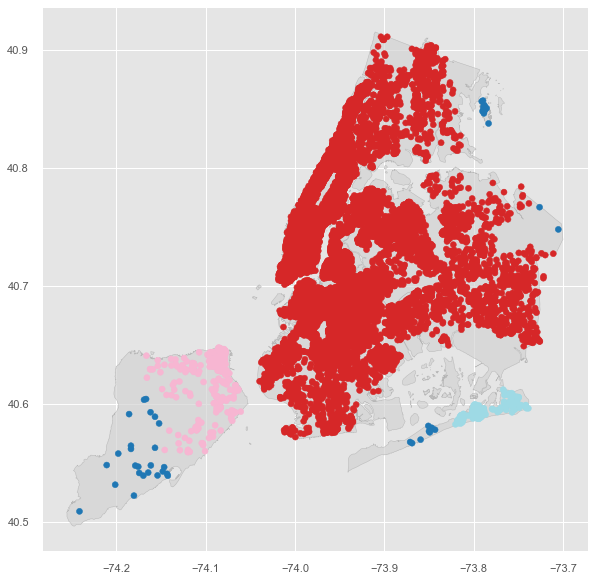

In [379]:
db_LatLong = listings_modeling[['latitude','longitude']]

db = DBSCAN(eps=0.45, min_samples=20).fit(LatLong_std)

db_LatLong['cluster'] = db.labels_

geo_df = gpd.GeoDataFrame(db_LatLong.drop(['longitude', 'latitude'], axis=1),
                           crs={'init': 'epsg:4326'},
                           geometry=[Point(xy) for xy in zip(db_LatLong.longitude, db_LatLong.latitude)])
      
# Set figure size
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
    
# Import NYC Neighborhood Shape Files
nyc_full = gpd.read_file('Shapefiles/neighborhoods_nyc.shp')
nyc_full.plot(ax=ax, alpha=0.7, edgecolor='darkgrey', color='lightgrey', zorder=1)
    
# Plot coordinates from geo_df on top of NYC map
geo_df.plot(ax=ax, column='cluster', cmap='tab20', zorder=1)

<AxesSubplot:>

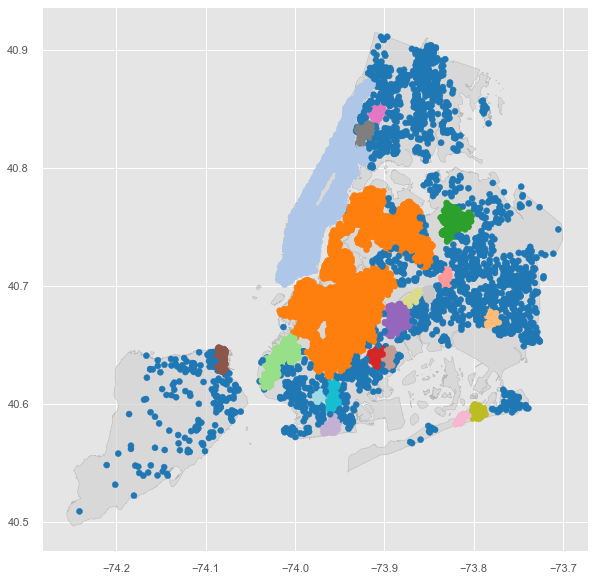

In [365]:
db_LatLong = listings_modeling[['latitude','longitude']]

db = DBSCAN(eps=0.1, min_samples=25).fit(LatLong_std)

db_LatLong['cluster'] = db.labels_

geo_df = gpd.GeoDataFrame(db_LatLong.drop(['longitude', 'latitude'], axis=1),
                           crs={'init': 'epsg:4326'},
                           geometry=[Point(xy) for xy in zip(db_LatLong.longitude, db_LatLong.latitude)])
      
# Set figure size
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
    
# Import NYC Neighborhood Shape Files
nyc_full = gpd.read_file('Shapefiles/neighborhoods_nyc.shp')
nyc_full.plot(ax=ax, alpha=0.7, edgecolor='darkgrey', color='lightgrey', zorder=1)
    
# Plot coordinates from geo_df on top of NYC map
geo_df.plot(ax=ax, column='cluster', cmap='tab20', zorder=1)

Build base model for DBSCAN and plot cluster mapping

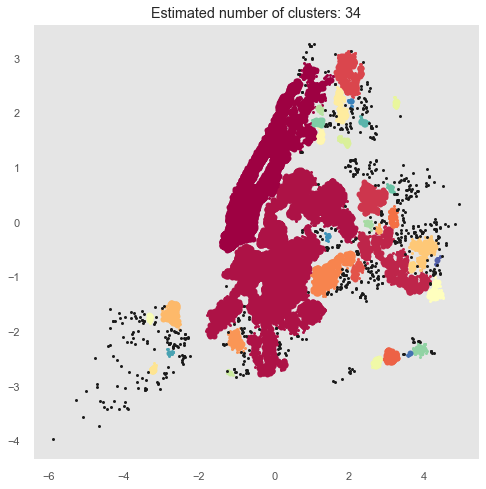

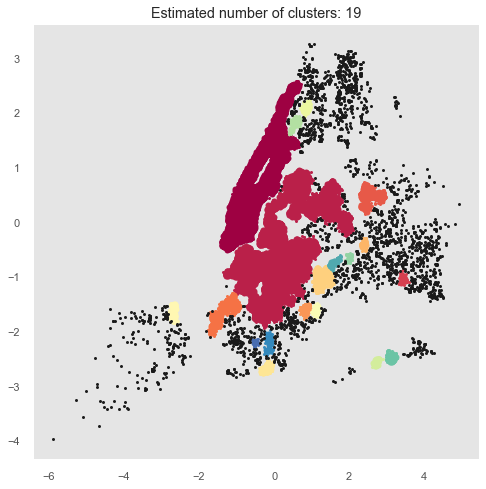

In [304]:
from sklearn.cluster import DBSCAN

#=====================================
# ENTER YOUR CODE HERE TO CHANGE MINPTS AND EPS FOR EACH DATASET
X2_minpts = 10 # from above
X2_eps = 0.1
X3_minpts = 25 # from above
X3_eps = 0.1
#=====================================

for i, (data, minpts, eps) in enumerate(zip([LatLong_std,LatLong_std],[X2_minpts,X3_minpts],[X2_eps,X3_eps])):

    db = DBSCAN(eps=eps, min_samples=minpts).fit(data)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # mark the samples that are considered "core"
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=(8,8))
    unique_labels = set(labels) # the unique labels
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        # plot the core points in this class
        plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=6)

        # plot the remaining points that are edge points
        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=3)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.grid()
    plt.show()

## Tune Hyperparameters for DBSCAN

See example code in kmeans section below. Kmeans has one loop to explore range of n_clusters. DBSCAN will need a nested loop to look at grid ranges for both min_samples and eps

In [ ]:
#Insert code for tuning

# Kmeans

Build base model with fixed clusters and plot centroids

In [ ]:
from sklearn.cluster import KMeans

#--------Change parameters below this line---------------------------
# CHANGE THE PARAMETERS HERE TO GET A CONSISTENTLY OPTIMAL CLUSTERING
# run kmeans algorithm (this is the most traditional use of k-means)
kmeans = KMeans(
    init='k-means++',    # initialization
    n_clusters=75,    # number of clusters
    n_init=1,         # number of different times to run k-means
    n_jobs=-1)
#--------Change parameters above this line---------------------------

kmeans.fit(LatLong)

# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(LatLong[:, 0], LatLong[:, 1], 'r.', markersize=1) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('K-means clustering for Lat-Long')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.grid()
plt.show()

Make predictions on labels and plot map of clusters

In [ ]:
label = kmeans.fit_predict(LatLong)

#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:

plt.figure(figsize=(15,4)) 
for i in u_labels:
    plt.scatter(LatLong[label == i , 0] , LatLong[label == i , 1] , label = i, s=1)
plt.grid()
plt.show()

In [ ]:
from sklearn.cluster import KMeans

#--------Change parameters below this line---------------------------
# CHANGE THE PARAMETERS HERE TO GET A CONSISTENTLY OPTIMAL CLUSTERING
# run kmeans algorithm (this is the most traditional use of k-means)
kmeans = KMeans(
    init='k-means++',    # initialization
    n_clusters=40,    # number of clusters
    n_init=1,         # number of different times to run k-means
    n_jobs=-1)
#--------Change parameters above this line---------------------------

kmeans.fit(LatLong)

# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(LatLong[:, 0], LatLong[:, 1], 'r.', markersize=1) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('K-means clustering for Lat-Long')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.grid()
plt.show()

In [ ]:
label = kmeans.fit_predict(LatLong)

#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:

plt.figure(figsize=(15,4)) 
for i in u_labels:
    plt.scatter(LatLong[label == i , 0] , LatLong[label == i , 1] , label = i, s=1)
plt.grid()
plt.show()

## Tune hyperparameters by looping through range of n_clusters

Plot SSE and Silhouette metrics to find optimal number of clusters

In [ ]:
from sklearn.metrics import silhouette_score

kmeans_silhouette = []
kmeans_SSE = []

for i in range(10,200,5):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 1, n_jobs=-1)
    kmeans.fit(LatLong)
    kmeans_SSE.append(kmeans.inertia_) #Collects all of the within cluster sum of squares
    kmeans_silhouette.append(silhouette_score(LatLong, kmeans.labels_, metric='euclidean'))

plt.plot(range(10,200,5), kmeans_SSE)
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

plt.plot(range(10,200,5), kmeans_silhouette)
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.show()

## **Based on plots above, setting number of clusters to 60 would be below the elbow on SSE metric and still in the higher silihouette range which drops off as you increase number of clusters**

## Run Tuned clustering model for both the modeling and validation data sets and plot cluster maps

In [ ]:
#--------Change parameters below this line---------------------------
# CHANGE THE PARAMETERS HERE TO GET A CONSISTENTLY OPTIMAL CLUSTERING
# run kmeans algorithm (this is the most traditional use of k-means)
kmeans_tuned = KMeans(
    init='k-means++',    # initialization
    n_clusters=60,    # number of clusters
    n_init=1,         # number of different times to run k-means
    n_jobs=-1)
#--------Change parameters above this line---------------------------

model_train = kmeans_tuned.fit(LatLong)

label = model_train.predict(LatLong)

#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:

plt.figure(figsize=(15,4)) 
for i in u_labels:
    plt.scatter(LatLong[label == i , 0] , LatLong[label == i , 1] , label = i, s=1)
plt.grid()
plt.show()

In [ ]:
Lat_val = listings_validation.latitude
Long_val = listings_validation.longitude

LatLong_val = np.column_stack((Lat_val, Long_val))

LatLong_val.shape

In [ ]:
label_val = model_train.predict(LatLong_val)

#Getting unique labels
 
u_labels = np.unique(label_val)
 
#plotting the results:

plt.figure(figsize=(15,4)) 
for i in u_labels:
    plt.scatter(LatLong_val[label_val == i , 0] , LatLong_val[label_val == i , 1] , label = i, s=1)
plt.grid()
plt.show()

In [ ]:
listings_modeling.head()

In [ ]:
listings_modeling['cluster'] = label
listings_modeling.head()

In [ ]:
listings_validation['cluster'] = label_val
listings_validation.head()

In [ ]:
#Create X and Y for modeling
X_price = listings_modeling.drop(['id','price','price_log','latitude','longitude'],axis=1) #droping rating_max
Y_price_log = listings_modeling['price_log']

#Create new X and Y for validation
X_price_valid = listings_validation.drop(['id','price','price_log','latitude','longitude'],axis=1) #droping rating_max
Y_price_log_valid = listings_validation['price_log']

#Standard scale the data
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

std.fit(X_price.values) # only std.fit on train set
X_price_std = std.transform(X_price.values)
X_price_valid_std = std.transform(X_price_valid.values)

In [ ]:
#Best model is RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500)

from sklearn.ensemble import RandomForestRegressor

rfRandomEstimator = RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500, n_jobs=8, random_state=0)
rfRandomEstimator.fit(X_price_std, Y_price_log)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
rf, rfMae = EvaluateRegressionEstimator('Random Forest Regressor', rfRandomEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(rf)

In [ ]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
randomForrestReg_weights = rfRandomEstimator.feature_importances_.ravel()
randomForrestReg_feature_names = X_price_valid.columns.values
randomForrestReg_ft_imp_df = pd.DataFrame({'feature_names':randomForrestReg_feature_names, 'weights':randomForrestReg_weights, 'absolute_weights': np.abs(randomForrestReg_weights)})
randomForrestReg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False)

In [ ]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

randomForrestReg_wt_plt_df = randomForrestReg_ft_imp_df.head(75)

randomForrestReg_weights = pd.Series(randomForrestReg_wt_plt_df['weights'].values,index=randomForrestReg_wt_plt_df['feature_names'])
ax = randomForrestReg_weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations for Random Forrest Regressor", fontsize=16)
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

One-hot encode clustering

In [ ]:
listings_modeling.cluster = pd.Categorical(listings_modeling.cluster)

Categoricals_to_convert = ['cluster']

# using pd get dummies for the category columns we are keeping
dummies = pd.get_dummies(listings_modeling[Categoricals_to_convert],drop_first=True)

#dropping original columns
listings_cluster1 = listings_modeling.drop(Categoricals_to_convert,axis=1)

#concating dummies to the data frame
listings_cluster1 = pd.concat([listings_cluster1,dummies],axis=1)

listings_cluster1.head()

In [ ]:
listings_validation.cluster = pd.Categorical(listings_validation.cluster)

Categoricals_to_convert = ['cluster']

# using pd get dummies for the category columns we are keeping
dummies = pd.get_dummies(listings_validation[Categoricals_to_convert],drop_first=True)

#dropping original columns
validation_cluster1 = listings_validation.drop(Categoricals_to_convert,axis=1)

#concating dummies to the data frame
validation_cluster1 = pd.concat([validation_cluster1,dummies],axis=1)

validation_cluster1.head()

In [ ]:
#Create X and Y for modeling
X_price = listings_cluster1.drop(['id','price','price_log','latitude','longitude'],axis=1) #droping rating_max
Y_price_log = listings_cluster1['price_log']

#Create new X and Y for validation
X_price_valid = validation_cluster1.drop(['id','price','price_log','latitude','longitude'],axis=1) #droping rating_max
Y_price_log_valid = validation_cluster1['price_log']

#Standard scale the data
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

std.fit(X_price.values) # only std.fit on train set
X_price_std = std.transform(X_price.values)
X_price_valid_std = std.transform(X_price_valid.values)

In [ ]:
#Best model is RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500)

from sklearn.ensemble import RandomForestRegressor

rfRandomEstimator = RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500, n_jobs=8, random_state=0)
rfRandomEstimator.fit(X_price_std, Y_price_log)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
rf, rfMae = EvaluateRegressionEstimator('Random Forest Regressor', rfRandomEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(rf)

**Base model results without clustering were:**
The average MAE for all cv folds is: 			 0.13133
The average MAE percentage (MAPE) for all cv folds is: 	 6.38
The average RMSE for all cv folds is: 			 0.18161
The average R2 for all cv folds is: 			 0.66462

In [ ]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
randomForrestReg_weights = rfRandomEstimator.feature_importances_.ravel()
randomForrestReg_feature_names = X_price_valid.columns.values
randomForrestReg_ft_imp_df = pd.DataFrame({'feature_names':randomForrestReg_feature_names, 'weights':randomForrestReg_weights, 'absolute_weights': np.abs(randomForrestReg_weights)})
randomForrestReg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False)

In [ ]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

randomForrestReg_wt_plt_df = randomForrestReg_ft_imp_df.head(75)

randomForrestReg_weights = pd.Series(randomForrestReg_wt_plt_df['weights'].values,index=randomForrestReg_wt_plt_df['feature_names'])
ax = randomForrestReg_weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations for Random Forrest Regressor", fontsize=16)
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

# Spectral Clustering

Build Base models

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph

#object to cluster on
# LatLong = np.column_stack((Lat, Long))

#nclust = n_clusters default is 8 

In [ ]:
#default model

X= LatLong

#running with default n_clusters, assign_labels = 'kmeans' default
spc = SpectralClustering(affinity = 'nearest_neighbors')
labels = spc.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

In [ ]:
#adjusting n_clusters
nclust = 16
X= LatLong

#running with default n_clusters, assign_labels = 'kmeans' default
spc = SpectralClustering(n_clusters=nclust ,affinity = 'nearest_neighbors')
labels = spc.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

#hard to say if this is better

In [ ]:
# using professors code to calculate our own affinity metrix. 
#using default n_clusters

from sklearn.metrics.pairwise import pairwise_distances

X= LatLong

d = pairwise_distances(X, metric='euclidean')
d = np.exp(- d**2 / (2.* 0.1**2)) # convert from euclidean distance to similarity
# this is Eric's function, empirically it works

spc = SpectralClustering(affinity = 'precomputed', eigen_solver = 'arpack')
labels = spc.fit_predict(d) 

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

Tune Hyperparameters for spectral clustering

In [ ]:
#Insert Code for tuning see example code above in kmeans section